# Violent Precipitation Events Map

**Violent Precipitation Events (VPE)**: Counting the number of events in one year during which the cumulative precipitation in 3 days exceeded 100 mm. This index is very important because it provides an estimate of the meteorological contribution to the hydrological risk of a given area.

Import the meteoblue_dataset_sdk package, which allows to get data from the meteoblue API directly with Python.
To install the package you can use pip (pip -install meteoblue_dataset_skd), conda or brew.

In [1]:
import meteoblue_dataset_sdk

Import several packages which are required for the API call, handling the dataframes and plotting.

In [2]:
import datetime as dt
import dateutil.parser
import pandas as pd
import numpy as np
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import matplotlib.pyplot as plt

Define functions to transform the output of the dataset API into a pandas dataframe

In [3]:
def meteoblue_timeinterval_to_timestamps(t):
    if len(t.timestrings) > 0:
        def map_ts(time):
            if "-" in time:
                return dateutil.parser.parse(time.partition("-")[0])
            return dateutil.parser.parse(time)

        return list(map(map_ts, t.timestrings))

    timerange = range(t.start, t.end, t.stride)
    return list(map(lambda t: dt.datetime.fromtimestamp(t), timerange))

def meteoblue_result_to_dataframe(geometry):
    t = geometry.timeIntervals[0]
    timestamps = meteoblue_timeinterval_to_timestamps(t)

    n_locations = len(geometry.lats)

    df = pd.DataFrame(
        {
            "timestamp": np.tile(timestamps, n_locations),
        }
    )
    for code in geometry.codes:
        name = str(code.code) + "_" + code.level + "_" + code.aggregation
        df[name] = list(code.timeIntervals[0].data)
    return df

Select **year** of analysis, **map resolution** (in °) and **apikey**

In [4]:
apikey =  "X-X-X-X-X"
year = 2021
resolution = 0.025 

Define the query for **violent precipitation events**:

In [5]:
query_map = {
    "units": {
        "temperature": "C",
        "velocity": "km/h",
        "length": "metric",
        "energy": "watts"
    },
    "geometry": {
        "type": "GeonamePolygon",
        "geonameid": 3175395
    },
    "format": "json",
    "timeIntervals": [
        str(year)+"-01-01T+00:00/"+str(year)+"-12-31T+00:00"
    ],
    "timeIntervalsAlignment": "none",
    "queries": [
        {
            "domain": "ERA5",
            "gapFillDomain": None,
            "timeResolution": "daily",
            "codes": [
                {
                    "code": 61,
                    "level": "sfc",
                    "aggregation": "sum"
                }
            ],
            "transformations": [
                {
                    "type": "timeLaggedAggregation",
                    "aggregation": "sum",
                    "nTimesteps": 3
                },
                {
                    "type": "valueIsAbove",
                    "valueMin": 100,
                    "returnClassification": "zeroOrOne"
                },
                {
                    "type": "aggregateYearly",
                    "aggregation": "sum"
                },
                {
                    "type": "spatialTransform",
                    "gridResolution": resolution,
                    "interpolationMethod": "linear",
                    "spatialAggregation": "mean",
                    "disjointArea": "discard",
                    "elevationDownscale": "disabled"
                }
            ]
        }
    ]
}



**API call**:

In [6]:
client = meteoblue_dataset_sdk.Client(apikey)

result = client.query_sync(query_map)
lats = list(result.geometries[0].lats)
lons = list(result.geometries[0].lons)
data = list(meteoblue_result_to_dataframe(result.geometries[0])["61_sfc_sum"])


Set colormap and scale limits:

In [7]:
cmap = "RdBu_r"
min_val = 0
max_val = 10

Poduce the plot:

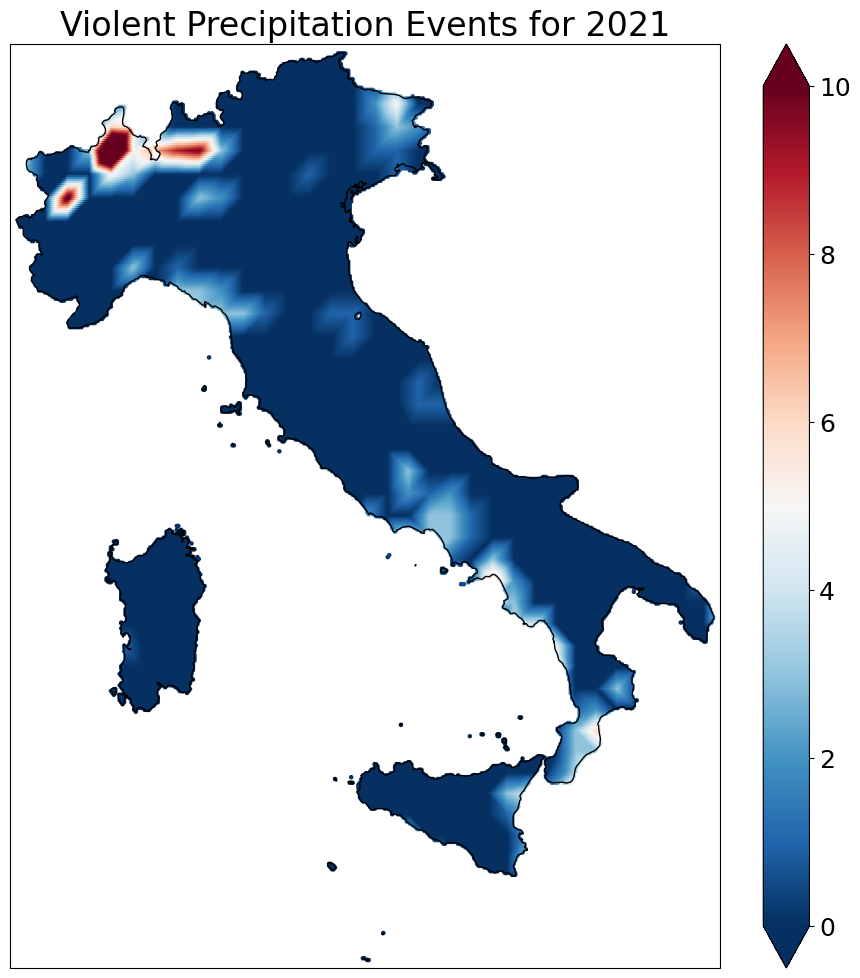

In [8]:
xs, ys = np.meshgrid(lons, lats)
dataMesh = np.empty_like(xs)
for i, j, d in zip(lons, lats, data):
    dataMesh[lons.index(i), lats.index(j)] = d

# request data for use by geopandas
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

# get geometry of a country
poly = [df.loc[df['ADMIN'] == "Italy"]['geometry'].values[0]]

stamen_terrain = cimgt.Stamen('terrain-background')

# projections that involved
st_proj = stamen_terrain.crs  #projection used by Stamen images
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat

# create fig and axes using intended projection
fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(1, 1, 1, projection=st_proj)
ax.set_title("Violent Precipitation Events for "+str(year), fontsize = 24)
ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')
pad1 = .1  #padding, degrees unit
exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
ax.set_extent(exts, crs=ll_proj)
img=ax.scatter(lons, lats, c=data,s=5, cmap = cmap,vmin=min_val,vmax=max_val, transform =ccrs.PlateCarree())
color_bar = fig.colorbar(img, ax = ax, extend = 'both', orientation = "vertical", fraction = 0.046, pad = 0.04)
color_bar.ax.tick_params(labelsize=18)
plt.show()